In [36]:
import sys
import os
import math
import glob
import json

import argparse
import functools

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely import wkt
from shapely.geometry import Polygon, shape, Point, mapping
from shapely.ops import transform
import pyproj

import dask
import dask.dataframe as ddf
from dask.distributed import LocalCluster, Client

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import TwoSlopeNorm

from tqdm import tqdm

In [2]:
def get_conf(conf_path):
    with open(conf_path, 'r') as f:
        config = json.load(f)
    return config

In [3]:
results_path = "../results_gen_bak"
config_path = '../cell_stats/config-main1.json'
default_name = 'cell_stats_main1'

sample_polygons = gpd.read_file('../cell_stats/sample_polygons.geojson',driver='GeoJSON')

config = get_conf(config_path)

In [4]:
config

{'dggss': [{'name': ['h3'],
   'global_res': [2, 3, 4, 5, 6],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['s2'],
   'global_res': [2, 3, 4, 5, 6, 7, 8, 9],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['rhpix'],
   'global_res': [2, 3, 4, 5, 6],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'ISEA7H'],
   'global_res': [2, 3, 4, 5, 6],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'FULLER7H'],
   'global_res': [2, 3, 4, 5, 6],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'ISEA4T'],
   'global_res': [2, 3, 4, 5, 6, 7, 8],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'FULLER4T'],
   'global_res': [2, 3, 4, 5, 6, 7, 8],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'ISEA4D'],
   'global_res': [2, 3, 4, 5, 6, 7, 8],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID', 'FULLER4D'],
   'global_res': [2, 3, 4, 5, 6, 7, 8],
   'sample_res': [],
   'proj': 'LAEA'},
  {'name': ['DGGRID

In [5]:
def get_area_perimeter_from_lambert(geom):
    '''Area from cell's lambert azimutal projection'''
    perimeter = np.nan
    area = np.nan
    try:
        if (-180 <= geom.centroid.x <= 180) and (-90 <= geom.centroid.y <= 90):
            proj_str = f"+proj=laea +lat_0={geom.centroid.y} +lon_0={geom.centroid.x}"
            project = pyproj.Transformer.from_crs('EPSG:4236', proj_str, always_xy=True).transform
            perimeter = transform(project, geom).length
            area = transform(project, geom).area
        else:
            # print(f'invalid centroid {geom.centroid}')
            pass
    except Exception as ex:
        print(f'invalid centroid Exception')
        print(ex)
    # return (area, perimeter)
    return pd.Series([area, perimeter])

In [6]:
sample_polygons[['area', 'perimeter']] = sample_polygons['geometry'].apply(get_area_perimeter_from_lambert)

# for the normalised area
sample_polygons['norm_area'] = sample_polygons['area']/sample_polygons['area'].mean()

In [7]:
[print( f"{idx}: {name['name']}") for (idx, name) in enumerate(config['dggss'])]

0: ['h3']
1: ['s2']
2: ['rhpix']
3: ['DGGRID', 'ISEA7H']
4: ['DGGRID', 'FULLER7H']
5: ['DGGRID', 'ISEA4T']
6: ['DGGRID', 'FULLER4T']
7: ['DGGRID', 'ISEA4D']
8: ['DGGRID', 'FULLER4D']
9: ['DGGRID', 'ISEA3H']
10: ['DGGRID', 'FULLER3H']
11: ['eaggr', 'ISEA4T']
12: ['eaggr', 'ISEA3H']


[None, None, None, None, None, None, None, None, None, None, None, None, None]

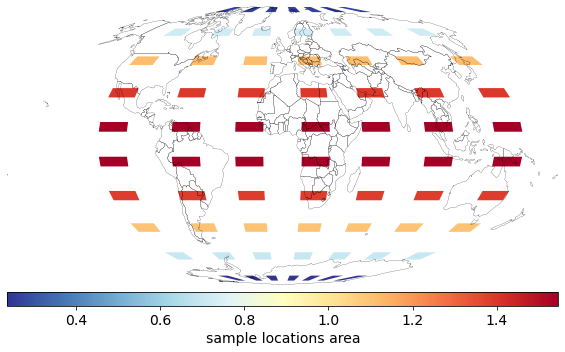

In [8]:
# world_countries NaturalEarth\ne_110m_admin_0_countries\ne_110m_admin_0_countries.shp
world_countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


fig, ax = plt.subplots(figsize=(10,5))
divider = make_axes_locatable(ax)
cax = divider.append_axes("bottom", size="5%", pad=0.1)

# vmin, vmax, vcenter = 0.5, 1.3, 1
# norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

# vmin, vmax, vcenter = sample_polygons['norm_area'].min(), sample_polygons['norm_area'].max(), 1
# norm = TwoSlopeNorm(vmin=vmin, vcenter=vcenter, vmax=vmax)

sample_polygons.to_crs('proj=moll').plot(column='norm_area', ax=ax, legend=True,cax=cax, cmap='RdYlBu_r', legend_kwds={'label': "sample locations",'orientation': "horizontal"})

world_countries.boundary.to_crs('proj=moll').plot(color=None, edgecolor='black',linewidth = 0.2,ax=ax)
ax.axis('off')
cb_ax = fig.axes[1] 
cb_ax.tick_params(labelsize=14)
cb_ax.set_xlabel(xlabel= "sample locations area",fontsize=14)
ax.margins(0)
ax.tick_params(left=False, labelleft=False, bottom=False, labelbottom=False)
plt.tight_layout()
# plt.savefig(r'd:\UTCloud\DGGS\results\area_statistics\h3_area_map.png', bbox_inches="tight",dpi=300)



In [9]:
counter = 0
counter_step2 = 0
found_files = []
found_step2_files = []

for dggs in config['dggss']:
    for res in dggs['global_res']:
        
        params = [dggs['name'], res, dggs['proj'], None]
        d_name, res, p_name = params[0], params[1], params[2]

        name = d_name[0]
        if len(d_name) > 1:
            name = '_'.join(d_name)

        name = f"{name}_{res}_{p_name}"
        parquet_file_name = os.path.join(results_path, f"{name}.parquet")
        

        if os.path.exists(parquet_file_name):
            # print(f"{parquet_file_name} file exists, ok")
            counter = counter + 1
            found_files.append(parquet_file_name)
        else:
            print(f"{parquet_file_name} file MISSING")
        
        fgb_file_name = os.path.join(results_path, f"{name}_step2.fgb")
        
        if os.path.exists(fgb_file_name):
            # print(f"{fgb_file_name} file exists, ok")
            counter_step2 = counter + 1
            found_step2_files.append(parquet_file_name)
        else:
            print(f"{fgb_file_name} file MISSING")
    
    for res in dggs['sample_res']:
        
        params = [dggs['name'], res, dggs['proj'], None]
        d_name, res, p_name = params[0], params[1], params[2]

        for idx, row in sample_polygons.iterrows():
            name = d_name[0]
            if len(d_name) > 1:
                name = '_'.join(d_name)

            name = f"{name}_{res}_{p_name}_sample_id_{idx}"
            parquet_file_name = os.path.join(results_path, f"{name}.parquet")

            if os.path.exists(parquet_file_name):
                # print(f"{parquet_file_name} file exists, ok")
                counter = counter + 1
                found_files.append(parquet_file_name)
            else:
                print(f"{parquet_file_name} file MISSING")


assert(len(set(found_files)) == counter)

import glob

all_parquet = glob.glob(os.path.join(results_path, "*.parquet"))
all_count = len(all_parquet)

print(f"{counter} config based parquet files (vs {all_count}) glob")

diff = set(all_parquet).difference(set(found_files))

all_step2 = glob.glob(os.path.join(results_path, "*_step2.fgb"))
all_count_step2 = len(all_step2)

print(f"{counter_step2} config based step2 files (vs {all_count_step2}) glob")

diff_step2 = set(all_step2).difference(set(found_step2_files))

../results_gen_bak/h3_5_LAEA_step2.fgb file MISSING
../results_gen_bak/h3_6_LAEA_step2.fgb file MISSING
../results_gen_bak/s2_9_LAEA_step2.fgb file MISSING
../results_gen_bak/rhpix_6_LAEA_step2.fgb file MISSING
../results_gen_bak/DGGRID_ISEA7H_6_LAEA_step2.fgb file MISSING
../results_gen_bak/DGGRID_FULLER7H_6_LAEA_step2.fgb file MISSING
../results_gen_bak/DGGRID_ISEA4T_8_LAEA_step2.fgb file MISSING
../results_gen_bak/DGGRID_FULLER4T_8_LAEA_step2.fgb file MISSING
../results_gen_bak/DGGRID_ISEA4D_8_LAEA_step2.fgb file MISSING
../results_gen_bak/DGGRID_FULLER4D_8_LAEA_step2.fgb file MISSING
../results_gen_bak/eaggr_ISEA4T_8_LAEA_step2.fgb file MISSING
../results_gen_bak/eaggr_ISEA3H_6_LAEA_step2.fgb file MISSING
78 config based parquet files (vs 78) glob
78 config based step2 files (vs 66) glob


In [ ]:
found_files


In [10]:
quick_stats_fgb = []

for parquet_file_name in tqdm(found_files):
    
    fgb_file_name = parquet_file_name.replace(".parquet", "_step2.fgb")
    if os.path.isfile(fgb_file_name):
        df = gpd.read_file(fgb_file_name)
        rows = len(df.index)
        size = os.stat(fgb_file_name).st_size
        # print(f"{parquet_file_name} {rows}")
        quick_stats_fgb.append( (fgb_file_name.replace('../results_gen_bak/', ''), rows, size) )

qs = pd.DataFrame(quick_stats_fgb, columns=['filename', 'num_rows', 'filesize'])

qs.sort_values(by='filename').to_csv('../results_gen_bak/quick_stats_fgb.csv', index=False)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 78/78 [02:43<00:00,  2.09s/it]


In [11]:
qs = pd.read_csv('../results_gen_bak/quick_stats_fgb.csv')

qs.sort_values(by=['num_rows'], ascending=False).head(15)

,filename,num_rows,filesize
65,s2_8_LAEA_step2.fgb,393216,98567040
58,rhpix_5_LAEA_step2.fgb,353566,88628200
45,eaggr_ISEA3H_5_LAEA_step2.fgb,335711,97087848
37,DGGRID_ISEA4T_7_LAEA_step2.fgb,327680,76896480
51,eaggr_ISEA4T_7_LAEA_step2.fgb,327680,79517920
16,DGGRID_FULLER4T_7_LAEA_step2.fgb,327680,76896480
54,h3_4_LAEA_step2.fgb,288122,83748256
20,DGGRID_FULLER7H_5_LAEA_step2.fgb,168072,47509168
41,DGGRID_ISEA7H_5_LAEA_step2.fgb,168071,47508888
31,DGGRID_ISEA4D_7_LAEA_step2.fgb,163840,41070160


In [12]:
def get_cells_area_stats(df):
    
    # Filter out invalid geometry
    try:
        # df['crossed'] = df['geometry'].apply(check_for_geom)
        date_line_cross_error_cells = len(df[df['crossed']])
        df = df[~df['crossed']]
        
        other_geom_anomalies = len(df[(df['area']<df['area'].quantile(0.005))&(df['area']>df['area'].quantile(0.995))])
        df = df[(df['area']>df['area'].quantile(0.005))&(df['area']<df['area'].quantile(0.995))]
        df['area'] = df['area'] / 1000000
        df['norm_area'] = df['area']/df['area'].mean()
        
        area_min = df['area'].min()
        area_max = df['area'].max()
        area_std = df['area'].std()
        area_mean = df['area'].mean()
        area_median = df['area'].median()
        
        ipq_min = df['ipq'].min()
        ipq_max = df['ipq'].max()
        ipq_std = df['ipq'].std()
        ipq_mean = df['ipq'].mean()
        ipq_median = df['ipq'].median()
        
        perimeter_min = df['perimeter'].min()
        perimeter_max = df['perimeter'].max()
        perimeter_std = df['perimeter'].std()
        perimeter_mean = df['perimeter'].mean()
        perimeter_median = df['perimeter'].median()
        
        norm_area_min = df['norm_area'].min()
        norm_area_max = df['norm_area'].max()
        norm_area_std = df['norm_area'].std()
        norm_area_mean = df['norm_area'].mean()
        norm_area_median = df['norm_area'].median()
        
        num_cells = len(df)
        
        stats_pd = pd.DataFrame({'area_min':[area_min],'area_max':[area_max], 'area_std':[area_std],'area_mean':[area_mean],'area_median':[area_median],
                                'ipq_min':[ipq_min],'ipq_max':[ipq_max], 'ipq_std':[ipq_std],'ipq_mean':[ipq_mean],'ipq_median':[ipq_median],
                                'perimeter_min':[perimeter_min],'perimeter_max':[perimeter_max], 'perimeter_std':[perimeter_std],'perimeter_mean':[perimeter_mean],'perimeter_median':[perimeter_median],
                                'norm_area_min':[norm_area_min],'norm_area_max':[norm_area_max], 'norm_area_std':[norm_area_std],'norm_area_mean':[norm_area_mean],'norm_area_median':[norm_area_median],
                                'num_cells':[num_cells], 'date_line_cross_error_cells':[date_line_cross_error_cells],'other_geom_anomalies':other_geom_anomalies})
    
        return stats_pd
    except Exception as ex:
        print(ex)
        print(len(df))
        return None

In [13]:
filename = "DGGRID_ISEA4T_8_LAEA_step2.fgb"
# filename = "h3_5_LAEA_step2.fgb"

def csv_fname(filename):
    tx = filename.split("_")
    nums = len(tx)
    baset = "_".join(tx[:-3])
    fname = f"{baset}_{tx[-3]}_stats.csv"

    return (fname, baset, tx[-3])

csv_fname(filename)

('DGGRID_ISEA4T_8_stats.csv', 'DGGRID_ISEA4T', '8')

In [14]:
done_files = []
    
for idx, row in qs.loc[qs["num_rows"] < 400000].iterrows():
    fname = '../results_gen_bak/' + row["filename"]
    df = gpd.read_file(fname)
    results = get_cells_area_stats(df)
    outfile, baset, res = csv_fname(row["filename"])
    results['baset'] = baset
    results['res'] = res
    results.to_csv('../results_gen_bak/' + outfile, index=False)
    print(f"{baset} {res} stats")
    done_files.append(outfile)

DGGRID_FULLER3H 2 stats
DGGRID_FULLER3H 3 stats
DGGRID_FULLER3H 4 stats
DGGRID_FULLER3H 5 stats
DGGRID_FULLER3H 6 stats
DGGRID_FULLER4D 2 stats
DGGRID_FULLER4D 3 stats
DGGRID_FULLER4D 4 stats
DGGRID_FULLER4D 5 stats
DGGRID_FULLER4D 6 stats
DGGRID_FULLER4D 7 stats
DGGRID_FULLER4T 2 stats
DGGRID_FULLER4T 3 stats
DGGRID_FULLER4T 4 stats
DGGRID_FULLER4T 5 stats
DGGRID_FULLER4T 6 stats
DGGRID_FULLER4T 7 stats
DGGRID_FULLER7H 2 stats
DGGRID_FULLER7H 3 stats
DGGRID_FULLER7H 4 stats
DGGRID_FULLER7H 5 stats
DGGRID_ISEA3H 2 stats
DGGRID_ISEA3H 3 stats
DGGRID_ISEA3H 4 stats
DGGRID_ISEA3H 5 stats
DGGRID_ISEA3H 6 stats
DGGRID_ISEA4D 2 stats
DGGRID_ISEA4D 3 stats
DGGRID_ISEA4D 4 stats
DGGRID_ISEA4D 5 stats
DGGRID_ISEA4D 6 stats
DGGRID_ISEA4D 7 stats
DGGRID_ISEA4T 2 stats
DGGRID_ISEA4T 3 stats
DGGRID_ISEA4T 4 stats
DGGRID_ISEA4T 5 stats
DGGRID_ISEA4T 6 stats
DGGRID_ISEA4T 7 stats
DGGRID_ISEA7H 2 stats
DGGRID_ISEA7H 3 stats
DGGRID_ISEA7H 4 stats
DGGRID_ISEA7H 5 stats
eaggr_ISEA3H 2 stats
eaggr_ISEA3H 

In [ ]:
done_files

In [19]:
all_stats = []

def mini_split(baset):
    tx = baset.split("_")
    baset = "_".join(tx[:-1])
    res = tx[-1]

    return pd.Series([baset, res])

for fn in done_files:
    fname = fn.replace("_LAEA", "")
    df = pd.read_csv('../results_gen_bak/' + fname)
    # df[["baset", "res"]] = df["baset"].apply(mini_split)
    all_stats.append(df)

all_df = pd.concat(all_stats, axis=0).reset_index(drop=True)

In [20]:
all_df

,area_min,area_max,area_std,area_mean,area_median,ipq_min,ipq_max,ipq_std,ipq_mean,ipq_median,...,norm_area_min,norm_area_max,norm_area_std,norm_area_mean,norm_area_median,num_cells,date_line_cross_error_cells,other_geom_anomalies,baset,res
0,4.001171e+06,5.919260e+06,549661.042791,5.533242e+06,5.676563e+06,0.864792,0.904839,0.012519,0.899720,0.904034,...,0.723115,1.069763,0.099338,1.0,1.025902,80,10,0,DGGRID_FULLER3H,2
1,1.452315e+06,1.992182e+06,88836.280526,1.876371e+06,1.902775e+06,0.864792,0.906707,0.007227,0.899985,0.903390,...,0.774002,1.061721,0.047345,1.0,1.014072,249,17,0,DGGRID_FULLER3H,3
2,4.316232e+05,6.615221e+05,26037.416538,6.286146e+05,6.308169e+05,0.864799,0.906637,0.004438,0.901906,0.902269,...,0.686626,1.052349,0.041420,1.0,1.003504,772,32,0,DGGRID_FULLER3H,4
3,1.970439e+05,2.216655e+05,6035.532952,2.098848e+05,2.095512e+05,0.890752,0.906871,0.003824,0.900937,0.901375,...,0.938819,1.056129,0.028756,1.0,0.998411,2357,49,0,DGGRID_FULLER3H,5
4,6.547990e+04,7.391382e+04,2005.944307,6.998367e+04,6.992425e+04,0.891224,0.906864,0.003267,0.901466,0.901652,...,0.935645,1.056158,0.028663,1.0,0.999151,7132,86,0,DGGRID_FULLER3H,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,2.303565e+05,4.134775e+05,49331.249543,3.321368e+05,3.391857e+05,0.697744,0.785394,0.017801,0.767094,0.772866,...,0.693559,1.244901,0.148527,1.0,1.021223,1487,33,0,s2,4
62,5.391634e+04,1.045714e+05,12533.831828,8.309832e+04,8.445932e+04,0.688205,0.785398,0.017994,0.767138,0.773325,...,0.648826,1.258405,0.150831,1.0,1.016378,6017,65,0,s2,5
63,1.358600e+04,2.610304e+04,3146.716707,2.077300e+04,2.102196e+04,0.683417,0.785398,0.018026,0.767159,0.773277,...,0.654022,1.256585,0.151481,1.0,1.011985,24201,129,0,s2,6
64,3.384899e+03,6.530371e+03,787.526711,5.192471e+03,5.263767e+03,0.681026,0.785398,0.018026,0.767165,0.773347,...,0.651886,1.257662,0.151667,1.0,1.013731,97065,257,0,s2,7


In [21]:
all_df.to_csv("../results_gen_bak/all_dggs_stats.csv", index=False)

In [37]:
all_df = pd.read_csv("../results_gen_bak/all_dggs_stats.csv")
all_df.head(3)

,area_min,area_max,area_std,area_mean,area_median,ipq_min,ipq_max,ipq_std,ipq_mean,ipq_median,...,norm_area_min,norm_area_max,norm_area_std,norm_area_mean,norm_area_median,num_cells,date_line_cross_error_cells,other_geom_anomalies,baset,res
0,4.001171e+06,5.919260e+06,549661.042791,5.533242e+06,5.676563e+06,0.864792,0.904839,0.012519,0.899720,0.904034,...,0.723115,1.069763,0.099338,1.0,1.025902,80,10,0,DGGRID_FULLER3H,2
1,1.452315e+06,1.992182e+06,88836.280526,1.876371e+06,1.902775e+06,0.864792,0.906707,0.007227,0.899985,0.903390,...,0.774002,1.061721,0.047345,1.0,1.014072,249,17,0,DGGRID_FULLER3H,3
2,4.316232e+05,6.615221e+05,26037.416538,6.286146e+05,6.308169e+05,0.864799,0.906637,0.004438,0.901906,0.902269,...,0.686626,1.052349,0.041420,1.0,1.003504,772,32,0,DGGRID_FULLER3H,4


In [38]:
display(all_df["baset"].unique())

paper_df = all_df.loc[all_df["baset"].isin([ 'h3', 's2', 'eaggr_ISEA4T', 'rhpix',
                                            'DGGRID_ISEA7H', 'DGGRID_FULLER7H', 'DGGRID_ISEA4D', 'DGGRID_FULLER4D', 'DGGRID_ISEA4T', 'DGGRID_FULLER4T' ]) ]

array(['DGGRID_FULLER3H', 'DGGRID_FULLER4D', 'DGGRID_FULLER4T',
       'DGGRID_FULLER7H', 'DGGRID_ISEA3H', 'DGGRID_ISEA4D',
       'DGGRID_ISEA4T', 'DGGRID_ISEA7H', 'eaggr_ISEA3H', 'eaggr_ISEA4T',
       'h3', 'rhpix', 's2'], dtype=object)

<AxesSubplot:xlabel='res', ylabel='ipq_median'>

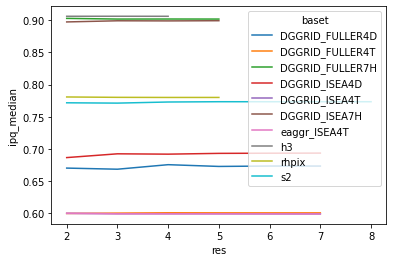

In [39]:
import seaborn as sns

sns.lineplot(data=paper_df, x="res", y="ipq_median", hue="baset", palette="tab10")

<AxesSubplot:xlabel='res', ylabel='ipq_mean'>

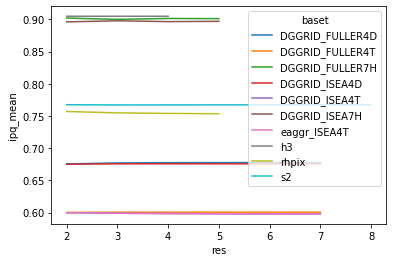

In [40]:
sns.lineplot(data=paper_df, x="res", y="ipq_mean", hue="baset", palette="tab10")

<AxesSubplot:xlabel='res', ylabel='ipq_std'>

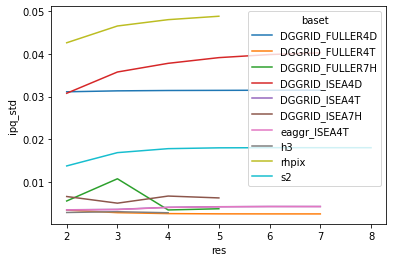

In [41]:
sns.lineplot(data=paper_df, x="res", y="ipq_std", hue="baset", palette="tab10")

<AxesSubplot:xlabel='res', ylabel='norm_area_median'>

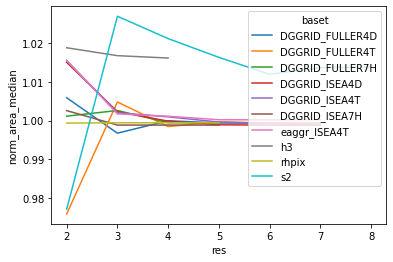

In [42]:
sns.lineplot(data=paper_df, x="res", y="norm_area_median", hue="baset", palette="tab10")

<AxesSubplot:xlabel='area_mean', ylabel='norm_area_std'>

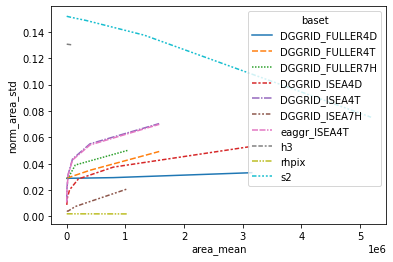

In [43]:
sns.lineplot(data=paper_df, x="area_mean", y="norm_area_std", hue="baset", style="baset", palette="tab10")

<AxesSubplot:xlabel='res', ylabel='area_mean'>

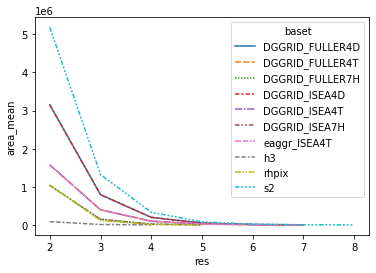

In [44]:
sns.lineplot(data=paper_df, x="res", y="area_mean", hue="baset", style="baset", palette="tab10")

In [45]:
tri = all_df.loc[all_df["baset"].isin(['DGGRID_FULLER3H', 'DGGRID_FULLER4T','DGGRID_ISEA3H', 'DGGRID_ISEA4T', 'eaggr_ISEA3H', 'eaggr_ISEA4T'])]

In [46]:
tri.groupby("baset").agg("mean")

,area_min,area_max,area_std,area_mean,area_median,ipq_min,ipq_max,ipq_std,ipq_mean,ipq_median,...,perimeter_median,norm_area_min,norm_area_max,norm_area_std,norm_area_mean,norm_area_median,num_cells,date_line_cross_error_cells,other_geom_anomalies,res
baset,,,,,,,,,,,,,,,,,,,,,
DGGRID_FULLER3H,1.229527e+06,1.773709e+06,134515.243423,1.663619e+06,1.697926e+06,0.875272,0.906384,0.006255,0.900803,0.902544,...,3.938256e+06,0.811642,1.059224,0.049104,1.0,1.008208,2118.000000,38.8,0.0,4.0
DGGRID_FULLER4T,3.260805e+05,3.786048e+05,15921.540706,3.510853e+05,3.450366e+05,0.592657,0.604598,0.002747,0.600559,0.600789,...,1.878660e+06,0.930571,1.064598,0.033668,1.0,0.996263,71823.333333,250.0,0.0,4.5
DGGRID_ISEA3H,1.375725e+06,1.714183e+06,81871.634706,1.659985e+06,1.691583e+06,0.873454,0.903762,0.006703,0.897187,0.899753,...,3.941003e+06,0.884101,1.021575,0.025995,1.0,1.006460,2116.000000,40.8,0.0,4.0
DGGRID_ISEA4T,3.006773e+05,3.907260e+05,22997.485713,3.507764e+05,3.550069e+05,0.585872,0.604600,0.003988,0.598567,0.599624,...,1.897085e+06,0.852162,1.139718,0.038936,1.0,1.002741,71823.333333,250.0,0.0,4.5
eaggr_ISEA3H,2.033930e+06,2.115421e+06,12442.961684,2.097867e+06,2.101090e+06,0.381778,0.903094,0.055490,0.874001,0.891599,...,4.700949e+06,0.978778,1.009133,0.003808,1.0,1.000797,94545.250000,2345.5,0.0,3.5
eaggr_ISEA4T,3.015753e+05,3.890098e+05,22803.072386,3.511941e+05,3.554221e+05,0.586497,0.604598,0.003968,0.598579,0.599605,...,1.898130e+06,0.853739,1.138007,0.038170,1.0,1.003196,71741.000000,333.0,0.0,4.5


In [47]:
paper_df.groupby("baset").agg("mean")

,area_min,area_max,area_std,area_mean,area_median,ipq_min,ipq_max,ipq_std,ipq_mean,ipq_median,...,perimeter_median,norm_area_min,norm_area_max,norm_area_std,norm_area_mean,norm_area_median,num_cells,date_line_cross_error_cells,other_geom_anomalies,res
baset,,,,,,,,,,,,,,,,,,,,,
DGGRID_FULLER4D,651812.416946,7.384486e+05,22604.791844,702044.068866,704715.100610,0.629680,0.742290,0.031368,0.677153,0.672477,...,2.530804e+06,0.930831,1.054868,0.029735,1.0,1.000126,35903.000000,133.333333,0.0,4.5
DGGRID_FULLER4T,326080.536394,3.786048e+05,15921.540706,351085.301894,345036.555930,0.592657,0.604598,0.002747,0.600559,0.600789,...,1.878660e+06,0.930571,1.064598,0.033668,1.0,0.996263,71823.333333,250.000000,0.0,4.5
DGGRID_FULLER7H,213564.810870,3.194233e+05,14598.051923,302448.081842,302842.510142,0.861890,0.906672,0.005879,0.901017,0.901764,...,1.499770e+06,0.836437,1.056926,0.036734,1.0,1.000670,48341.250000,171.250000,0.0,3.5
DGGRID_ISEA4D,623232.974568,7.508627e+05,33951.162071,701370.099022,709571.734502,0.596411,0.725054,0.037230,0.675547,0.691927,...,2.488773e+06,0.894891,1.078243,0.026962,1.0,1.002315,35903.000000,133.333333,0.0,4.5
DGGRID_ISEA4T,300677.307812,3.907260e+05,22997.485713,350776.371074,355006.927937,0.585872,0.604600,0.003988,0.598567,0.599624,...,1.897085e+06,0.852162,1.139718,0.038936,1.0,1.002741,71823.333333,250.000000,0.0,4.5
DGGRID_ISEA7H,263008.079827,3.069364e+05,5718.946770,302217.234927,302840.574326,0.877847,0.904428,0.006161,0.896739,0.898355,...,1.502123e+06,0.950849,1.017353,0.009178,1.0,0.999789,48340.250000,171.750000,0.0,3.5
eaggr_ISEA4T,301575.257943,3.890098e+05,22803.072386,351194.143085,355422.104261,0.586497,0.604598,0.003968,0.598579,0.599605,...,1.898130e+06,0.853739,1.138007,0.038170,1.0,1.003196,71741.000000,333.000000,0.0,4.5
h3,21915.420715,4.057730e+04,4381.665604,33671.192026,34296.288358,0.888742,0.908258,0.002909,0.904714,0.905822,...,5.614112e+05,0.648735,1.205017,0.130384,1.0,1.017293,110306.333333,301.000000,0.0,3.0
rhpix,294387.108628,2.965232e+05,572.545601,295097.110678,294913.328098,0.606872,0.785485,0.046454,0.754757,0.780169,...,1.520845e+06,0.997531,1.004625,0.001990,1.0,0.999427,98245.250000,204.750000,0.0,3.5


In [48]:
for idx, group in paper_df[['baset',
          'res',
          'num_cells',
          'area_std',
 'area_mean',
 'area_median',

           'norm_area_mean',
           'norm_area_median',
             'norm_area_min',
             'norm_area_max',
             'norm_area_std',
 'ipq_mean',
 'ipq_median',
 'date_line_cross_error_cells',
 'other_geom_anomalies'
]].groupby("baset"):
    display(group.sort_values(by=["res"]))

,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
5,DGGRID_FULLER4D,2,146,104557.013915,3.152696e+06,3.171343e+06,1.0,1.005915,0.929321,1.051575,0.033164,0.675545,0.670393,12,0
6,DGGRID_FULLER4D,3,608,23400.972459,7.950335e+05,7.924575e+05,1.0,0.996760,0.924842,1.051446,0.029434,0.677023,0.668661,24,0
7,DGGRID_FULLER4D,4,2484,5778.560113,1.991575e+05,1.991528e+05,1.0,0.999976,0.927306,1.056366,0.029015,0.677465,0.675689,50,0
8,DGGRID_FULLER4D,5,10036,1441.882847,4.981085e+04,4.978098e+04,1.0,0.999401,0.933402,1.056631,0.028947,0.677577,0.672969,102,0
9,DGGRID_FULLER4D,6,40348,360.277521,1.245358e+04,1.244505e+04,1.0,0.999316,0.935045,1.056570,0.028930,0.677643,0.673591,204,0
10,DGGRID_FULLER4D,7,161796,90.044206,3.113405e+03,3.111504e+03,1.0,0.999389,0.935069,1.056624,0.028921,0.677662,0.673560,408,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
11,DGGRID_FULLER4T,2,294,77622.141525,1.576768e+06,1.538719e+06,1.0,0.975869,0.929784,1.081300,0.049229,0.600257,0.600034,22,0
12,DGGRID_FULLER4T,3,1220,13914.062358,3.974833e+05,3.994051e+05,1.0,1.004835,0.924873,1.072528,0.035005,0.600554,0.600595,46,0
13,DGGRID_FULLER4T,4,4974,3037.350254,9.957219e+04,9.942041e+04,1.0,0.998476,0.927011,1.062364,0.030504,0.600626,0.601106,94,0
14,DGGRID_FULLER4T,5,20086,729.945240,2.490459e+04,2.489669e+04,1.0,0.999683,0.932890,1.058127,0.029310,0.600639,0.601024,190,0
15,DGGRID_FULLER4T,6,80722,180.687107,6.226707e+03,6.222838e+03,1.0,0.999379,0.933828,1.056629,0.029018,0.600639,0.600991,382,0
16,DGGRID_FULLER4T,7,323644,45.057754,1.556694e+03,1.555665e+03,1.0,0.999339,0.935043,1.056640,0.028945,0.600638,0.600987,766,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
17,DGGRID_FULLER7H,2,462,51907.415570,1.037238e+06,1.038440e+06,1.0,1.001158,0.688888,1.055743,0.050044,0.901878,0.902531,24,0
18,DGGRID_FULLER7H,3,3335,5783.807808,1.482723e+05,1.486615e+05,1.0,1.002625,0.789123,1.058740,0.039008,0.899921,0.901495,63,0
19,DGGRID_FULLER7H,4,23612,612.851246,2.124683e+04,2.123568e+04,1.0,0.999475,0.935888,1.056513,0.028844,0.901269,0.901551,160,0
20,DGGRID_FULLER7H,5,165956,88.133068,3.034857e+03,3.033099e+03,1.0,0.999420,0.931849,1.056707,0.029040,0.901001,0.901478,438,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
26,DGGRID_ISEA4D,2,146,167141.884251,3.149036e+06,3.196493e+06,1.0,1.015070,0.895837,1.067532,0.053077,0.675078,0.686678,12,0
27,DGGRID_ISEA4D,3,608,29706.478657,7.946605e+05,7.965104e+05,1.0,1.002328,0.866184,1.078583,0.037383,0.675649,0.692535,24,0
28,DGGRID_ISEA4D,4,2484,5653.164395,1.991504e+05,1.991246e+05,1.0,0.999870,0.854202,1.082851,0.028386,0.675671,0.692009,50,0
29,DGGRID_ISEA4D,5,10036,1003.665197,4.980779e+04,4.975442e+04,1.0,0.998929,0.916622,1.082495,0.020151,0.675647,0.693220,102,0
30,DGGRID_ISEA4D,6,40348,174.510890,1.245249e+04,1.243814e+04,1.0,0.998847,0.916993,1.079986,0.014014,0.675633,0.693481,204,0
31,DGGRID_ISEA4D,7,161796,27.269034,3.113183e+03,3.109597e+03,1.0,0.998848,0.919510,1.078014,0.008759,0.675603,0.693636,408,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
32,DGGRID_ISEA4T,2,294,110859.846411,1.575240e+06,1.599721e+06,1.0,1.015542,0.855427,1.106608,0.070377,0.599818,0.600177,22,0
33,DGGRID_ISEA4T,3,1220,21855.291924,3.971944e+05,3.980131e+05,1.0,1.002061,0.866426,1.132226,0.055024,0.598976,0.599634,46,0
34,DGGRID_ISEA4T,4,4974,4327.117192,9.954114e+04,9.963915e+04,1.0,1.000985,0.851288,1.143694,0.043471,0.598478,0.599611,94,0
35,DGGRID_ISEA4T,5,20086,791.540274,2.490049e+04,2.489154e+04,1.0,0.999641,0.847412,1.150637,0.031788,0.598192,0.599554,190,0
36,DGGRID_ISEA4T,6,80722,133.093598,6.226032e+03,6.221631e+03,1.0,0.999293,0.845498,1.153261,0.021377,0.598016,0.599421,382,0
37,DGGRID_ISEA4T,7,323644,18.024878,1.556574e+03,1.554901e+03,1.0,0.998925,0.846921,1.151882,0.011580,0.597921,0.599346,766,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
38,DGGRID_ISEA7H,2,462,21654.062257,1.035883e+06,1.038575e+06,1.0,1.002599,0.852654,1.014005,0.020904,0.895997,0.897037,24,0
39,DGGRID_ISEA7H,3,3334,1124.182018,1.487087e+05,1.485379e+05,1.0,0.998852,0.972798,1.027720,0.007560,0.897712,0.898818,63,0
40,DGGRID_ISEA7H,4,23608,84.594020,2.124257e+04,2.121829e+04,1.0,0.998857,0.995000,1.008968,0.003982,0.896382,0.898638,164,0
41,DGGRID_ISEA7H,5,165957,12.948783,3.034835e+03,3.031344e+03,1.0,0.998850,0.982945,1.018719,0.004267,0.896866,0.898926,436,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
46,eaggr_ISEA4T,2,287,110115.033716,1.577465e+06,1.602018e+06,1.0,1.015565,0.856293,1.099423,0.069805,0.599829,0.600329,29,0
47,eaggr_ISEA4T,3,1205,21528.465398,3.974492e+05,3.981428e+05,1.0,1.001745,0.870100,1.127893,0.054167,0.598998,0.599533,61,0
48,eaggr_ISEA4T,4,4945,4256.095668,9.956569e+04,9.967897e+04,1.0,1.001138,0.855059,1.143380,0.042747,0.598486,0.599517,125,0
49,eaggr_ISEA4T,5,20023,773.699887,2.490207e+04,2.490799e+04,1.0,1.000238,0.848952,1.150756,0.031070,0.598204,0.599469,253,0
50,eaggr_ISEA4T,6,80595,128.698082,6.226205e+03,6.227546e+03,1.0,1.000215,0.845825,1.154141,0.020670,0.598024,0.599443,509,0
51,eaggr_ISEA4T,7,323391,16.441567,1.556589e+03,1.557019e+03,1.0,1.000276,0.846201,1.152450,0.010563,0.597929,0.599340,1021,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
52,h3,2,5736,11294.916325,86838.015747,88476.023102,1.0,1.018863,0.651413,1.205130,0.130069,0.904700,0.905816,88,0
53,h3,3,40534,1618.709340,12403.702736,12612.276631,1.0,1.016815,0.647552,1.204945,0.130502,0.904727,0.905856,218,0
54,h3,4,284649,231.371148,1771.857594,1800.565342,1.0,1.016202,0.647241,1.204977,0.130581,0.904715,0.905795,597,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
55,rhpix,2,453,2028.506678,1.049384e+06,1.048721e+06,1.0,0.999368,0.997603,1.004870,0.001933,0.756932,0.780681,21,0
56,rhpix,3,4249,232.702613,1.166080e+05,1.165443e+05,1.0,0.999453,0.997526,1.004531,0.001996,0.754740,0.780107,75,0
57,rhpix,4,38731,26.066461,1.295674e+04,1.294959e+04,1.0,0.999448,0.997502,1.004516,0.002012,0.753935,0.779937,237,0
58,rhpix,5,349548,2.906651,1.439645e+03,1.438838e+03,1.0,0.999440,0.997495,1.004583,0.002019,0.753419,0.779952,486,0


,baset,res,num_cells,area_std,area_mean,area_median,norm_area_mean,norm_area_median,norm_area_min,norm_area_max,norm_area_std,ipq_mean,ipq_median,date_line_cross_error_cells,other_geom_anomalies
59,s2,2,85,389927.636908,5.185449e+06,5.066762e+06,1.0,0.977112,0.932362,1.149656,0.075197,0.767413,0.771650,9,0
60,s2,3,364,181663.685105,1.322308e+06,1.358029e+06,1.0,1.027015,0.794381,1.247404,0.137384,0.767050,0.771155,16,0
61,s2,4,1487,49331.249543,3.321368e+05,3.391857e+05,1.0,1.021223,0.693559,1.244901,0.148527,0.767094,0.772866,33,0
62,s2,5,6017,12533.831828,8.309832e+04,8.445932e+04,1.0,1.016378,0.648826,1.258405,0.150831,0.767138,0.773325,65,0
63,s2,6,24201,3146.716707,2.077300e+04,2.102196e+04,1.0,1.011985,0.654022,1.256585,0.151481,0.767159,0.773277,129,0
64,s2,7,97065,787.526711,5.192471e+03,5.263767e+03,1.0,1.013731,0.651886,1.257662,0.151667,0.767165,0.773347,257,0
65,s2,8,388775,196.935359,1.297986e+03,1.316015e+03,1.0,1.013889,0.652659,1.257636,0.151724,0.767169,0.773297,513,0


In [91]:
s1 = list( map(lambda s: s.upper(), all_df["baset"].unique().tolist() ))
print(s1)
print( [ a for a,b in enumerate(s1)])

['DGGRID_FULLER3H', 'DGGRID_FULLER4D', 'DGGRID_FULLER4T', 'DGGRID_FULLER7H', 'DGGRID_ISEA3H', 'DGGRID_ISEA4D', 'DGGRID_ISEA4T', 'DGGRID_ISEA7H', 'EAGGR_ISEA3H', 'EAGGR_ISEA4T', 'H3', 'RHPIX', 'S2']
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [102]:
print_data = [
# 'DGGRID_FULLER3H_6_LAEA_step2.fgb',
'DGGRID_FULLER4D_6_LAEA_step2.fgb', # (4,5?)
'DGGRID_FULLER4T_5_LAEA_step2.fgb',
'DGGRID_FULLER7H_4_LAEA_step2.fgb',
# 'DGGRID_ISEA3H_6_LAEA_step2.fgb',
'DGGRID_ISEA4D_6_LAEA_step2.fgb',
'DGGRID_ISEA4T_5_LAEA_step2.fgb',
'DGGRID_ISEA7H_4_LAEA_step2.fgb',
# 'eaggr_ISEA3H_3_LAEA_step2.fgb', # (probably rubbish and duplicates)
'eaggr_ISEA4T_5_LAEA_step2.fgb',
'h3_3_LAEA_step2.fgb',
'rhpix_4_LAEA_step2.fgb',
's2_6_LAEA_step2.fgb'
]

In [103]:
data_box = []

for datafile in print_data:
    res = datafile.split("_")[-3]
    dggs = datafile.split("_")[:-3]
    grid = gpd.read_file("../results_gen_bak/" + datafile)

    # remove bogus cells for nice plotting
    grid = grid[~grid['crossed']].dropna(subset=["perimeter", "area", "ipq"])
    # grid = grid[(grid['area']>grid['area'].quantile(0.001)) & (grid['area']<grid['area'].quantile(0.999))]
    
    # for the normalised area
    grid['norm_area'] = grid['area']/grid['area'].mean()
    
    df = grid[["area", "norm_area", "ipq"]].copy()
    df["res"] = int(res)
    dggs = ["RHEALPIX"] if "_".join(dggs) in "rhpix" else dggs
    df["dggs"] = ("_".join(dggs)).upper()
    data_box.append(df)

In [104]:
df = pd.concat(data_box, axis=0)
df.sample(5)

,area,norm_area,ipq,res,dggs
5685,2.560032e+10,1.233011,0.778813,6,S2
30052,1.241178e+10,0.996763,0.710133,6,DGGRID_ISEA4D
6315,2.067701e+10,0.973353,0.897556,4,DGGRID_FULLER7H
4321,1.842148e+10,0.887250,0.771236,6,S2
11771,2.530457e+10,1.016226,0.593794,5,DGGRID_ISEA4T


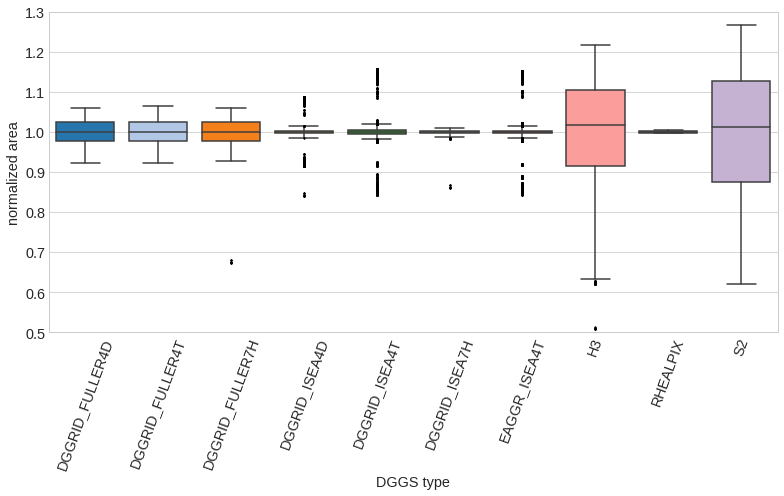

In [105]:
plt.figure(figsize=(11,7))
# fig, ax = plt.subplots(figsize=(10,5))

plt.style.use('seaborn-whitegrid')

#define design of the outliers
outlier_design = dict(marker='o', markerfacecolor='black', markersize=1,
                  linestyle='none', markeredgecolor='black')
#plot the boxplots
chart = sns.boxplot(x='dggs', y="norm_area", data=df, palette="tab20", saturation=0.9, showfliers=True, flierprops = outlier_design)

plt.xticks(
    rotation=70, 
    horizontalalignment='center',
    fontweight='light',
    fontsize='x-large', 
)

plt.xlabel('DGGS type', fontsize='x-large')

plt.yticks(
    rotation=0, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
)

plt.ylabel('normalized area', fontsize='x-large')

# plt.title("ASTER", fontsize='xx-large')

#set min and max values for y-axis
plt.ylim(0.5, 1.3)

plt.tight_layout()
plt.savefig("../results_gen_bak/box_plot_area.png", bbox_inches="tight",dpi=300)


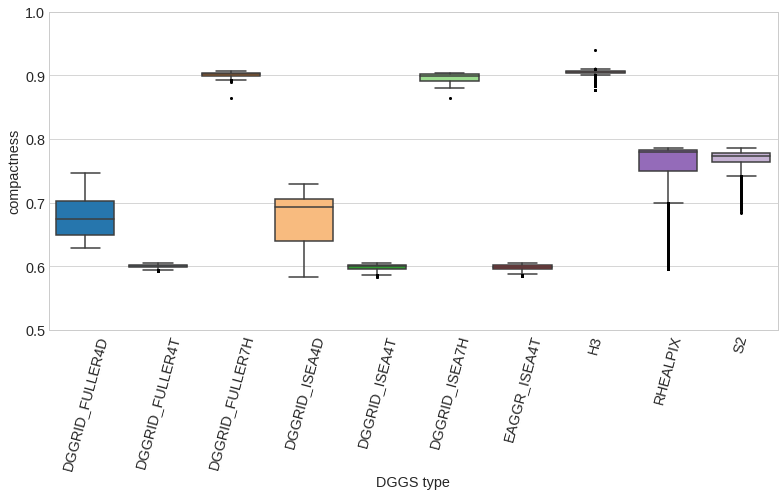

In [106]:
plt.figure(figsize=(11,7))
# fig, ax = plt.subplots(figsize=(10,5))

plt.style.use('seaborn-whitegrid')

#define design of the outliers
outlier_design = dict(marker='o', markerfacecolor='black', markersize=1,
                  linestyle='none', markeredgecolor='black')
#plot the boxplots
chart = sns.boxplot(x='dggs', y="ipq", data=df, palette="tab20", saturation=0.9, showfliers=True, flierprops = outlier_design)

plt.xticks(
    rotation=75, 
    horizontalalignment='center',
    fontweight='light',
    fontsize='x-large', 
)

plt.xlabel('DGGS type', fontsize='x-large')

plt.yticks(
    rotation=0, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large',
)

plt.ylabel('compactness', fontsize='x-large')

# plt.title("ASTER", fontsize='xx-large')

#set min and max values for y-axis
plt.ylim(0.5, 1.0)

plt.tight_layout()
plt.savefig("../results_gen_bak/box_plot_compactness.png", bbox_inches="tight",dpi=300)


In [107]:
# min/max for compactness
# 0.8 - 1.0
g_high = ['DGGRID_FULLER3H', 'DGGRID_FULLER7H', 'DGGRID_ISEA3H','DGGRID_ISEA7H','H3']

# 0.6 - 0.8
g_low = [ 'DGGRID_FULLER4D','DGGRID_ISEA4D',  'RHPIX', 'S2']

# 0.5 - 0.7
g_full_low = [ 'DGGRID_FULLER4T', 'DGGRID_ISEA4T',  'EAGGR_ISEA4T' ]
